# Assigment 9

* Building a MLP classifier for Sentiment Analysis, using Keras.
* We use data from [Large Movie Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

## Download and prepare our dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import tarfile
from sklearn.datasets import load_files

In [2]:
# Download Data
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz > /dev/null

--2024-02-14 09:53:33--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  10.9MB/s    in 13s     

2024-02-14 09:53:46 (6.06 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
from sklearn.datasets import load_files

movies_train = load_files(container_path="aclImdb/train", encoding="utf-8")
movies_test = load_files(container_path="aclImdb/test", encoding="utf-8")
print(type(movies_train))

<class 'sklearn.utils._bunch.Bunch'>


In [30]:
# Transform train dataset into a dataframe
data_train = {'reviews': movies_train.data, 'sentiment': movies_train.target}
df_train = pd.DataFrame(data_train)

# Transform test dataset into a dataframe
data_test = {'reviews': movies_test.data, 'sentiment': movies_test.target}
df_test = pd.DataFrame(data_test)

print(df_train.iloc[:10])
print('----------------------------------------------------------------------------------------')
print(df_test.iloc[:10])

                                             reviews  sentiment
0  Full of (then) unknown actors TSF is a great b...          2
1  Amount of disappointment I am getting these da...          2
2  The future, we are told, are what we make of i...          2
3  Dan Katzir has produced a wonderful film that ...          1
4  If you want Scream or anything like the big-st...          1
5  Although its mold of 1949 appears somewhat mel...          2
6  Gloomy Sunday - Ein Lied von Liebe und Tod dir...          2
7  This movie was ridiculous. The plot is complet...          2
8  Why was this movie made? No doubt to sucker in...          2
9  Outlandish premise that rates low on plausibil...          0
----------------------------------------------------------------------------------------
                                             reviews  sentiment
0  Don't hate Heather Graham because she's beauti...          1
1  I don't know how this movie has received so ma...          0
2  I caught thi

* Our dataset contains data with sentiment = 2. This means that they are unlabeled. We wont use them, so lets drop them.

In [31]:
# Drop rows where 'sentiment' is 2 from train & test sets
df_train = df_train[df_train['sentiment'] != 2]
df_test = df_test[df_test['sentiment'] != 2]


df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

# Define the train dataset with 5000 rows by test set
df_train = pd.concat([df_train, df_test[:5000]])

print(f'The size of training set is: {len(df_train)}')
print(f'The size of test set is: {len(df_test[5000:])}')

The size of training set is: 30000
The size of test set is: 20000


In [32]:
from sklearn.utils import shuffle

# Shuffle dataframes because they are sorted.
df_train = shuffle(df_train)
df_train.reset_index(inplace=True, drop=True)
df_test = shuffle(df_test)
df_test.reset_index(inplace=True, drop=True)

df_train.head()

,reviews,sentiment
0,"Because some people, like me, like to know EVE...",0
1,"Yeah, Madsen's character - whilst talking to t...",0
2,"""Journey of Hope"" tells of a poor Turkish fami...",1
3,Easily the worst movie I have ever seen in my ...,0
4,"An OK flick, set in Mexico, about a hit-man (S...",0


In [45]:
x_train = df_train.reviews
y_train = df_train.sentiment

* Now lets split our test data to development and test

In [46]:
# Split dev and test data
from sklearn.model_selection import train_test_split

x_dev, x_test, y_dev, y_test = train_test_split(df_test.reviews[5000:], df_test.sentiment[5000:], test_size=0.5, random_state=42)
print(f"Number of observations in dev set: {x_dev.shape[0]}")
print(f"Number of observations in test set: {x_test.shape[0]}")

Number of observations in dev set: 10000
Number of observations in test set: 10000


## Plot the length of each class (positive or negative) for every set

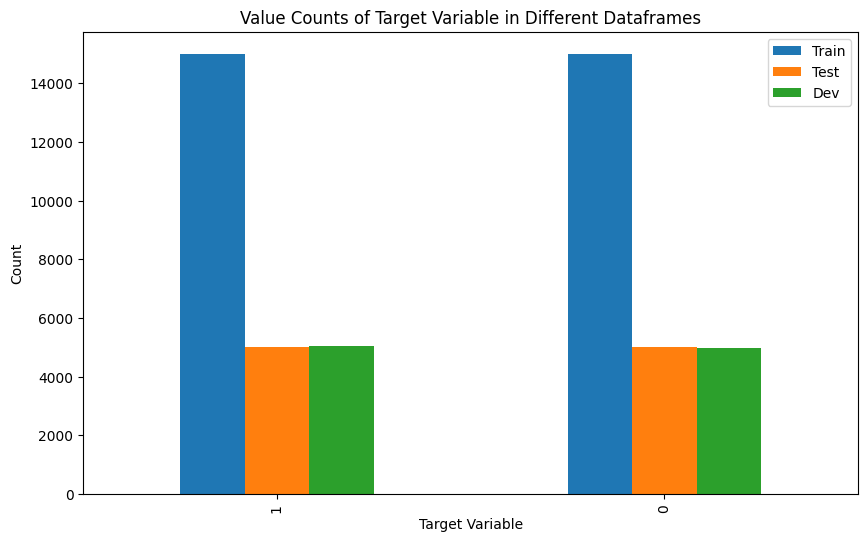

In [9]:

# Count the values of the ground truth (sentiments)
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
dev_counts = y_dev.value_counts()


# Create a DataFrame with the counts
counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts, 'Dev': dev_counts})

# Plot the bar plot
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Value Counts of Target Variable in Different Dataframes')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()


### Comments

* As we can observe via the above results we have very well balanced classes, thus we can proceed to the preprocessing of our data.

## Plot the size of each text for every set

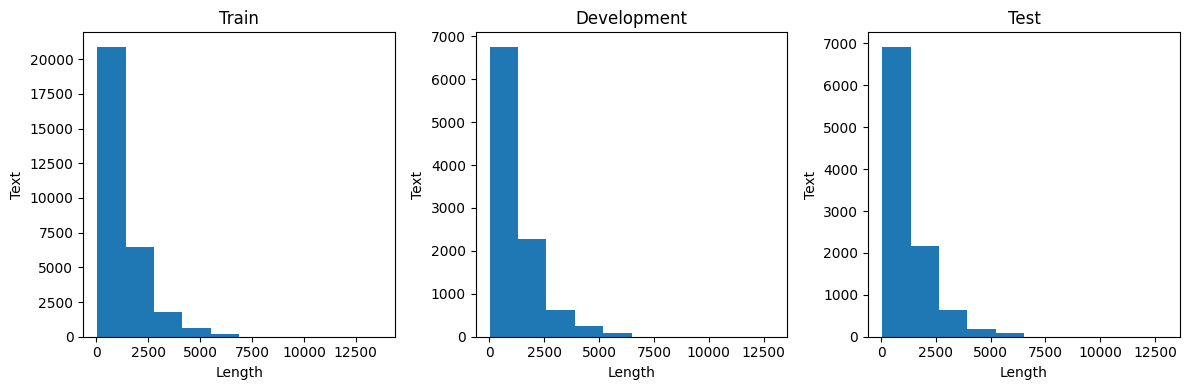

In [10]:
# Function to plot text lengths
def plot_text_lengths(ax, texts, title):
    text_lengths = [len(text) for text in texts]
    ax.hist(text_lengths)
    ax.set_xlabel('Length')
    ax.set_ylabel('Text')
    ax.set_title(title)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))

# Plot for texts1
plot_text_lengths(ax1, x_train, 'Train')

# Plot for texts2
plot_text_lengths(ax2, x_dev, 'Development')

plot_text_lengths(ax3, x_test, 'Test')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Preprocessing

* Replace non-word characters and numbers with empty string.
* Substitute multiple spaces with single space.
* Convert to lowercase.
* Remove stop words.
* Stemming with WordNetLemmatizer.

In [47]:
# Imports we need for preprocessing
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stemmer = WordNetLemmatizer()

# Import stop words for preprocessing
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def preprocess(contents):
  """
    Preprocesses a list of texts by removing non-word characters, single characters, extra spaces,
    converting to lowercase, splitting into words, lemmatizing, and reconstructing the documents.

    Parameters:
    - contents (list): A list of texts to be preprocessed.

    Returns:
    - pd.Series: A Pandas Series containing preprocessed documents.
    """

  docs = []

  for doc in contents:

      # Remove non-word (special) characters such as punctuation, numbers etc
      document = re.sub(r'\W', ' ', str(doc))

      # Remove HTML <BR>
      document = re.sub(r'\s+br\s+',' ', str(document))

      # Remove all single characters
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

      # Remove numbers
      document = re.sub(r'\b\d+\b', ' ', document)

      # Substitute multiple spaces with single space
      document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

      # Convert to Lowercase
      document = document.lower()

      # Split the document based on whitespaces (--> List of words)
      word_list = word_tokenize(document)

      # word_list = document.split()

      word_list = [word for word in word_list if word not in (stop_words)]

      # Lemmatization
      # word_list = [stemmer.lemmatize(word) for word in word_list]

      # # Reconstruct the document by joining the words on each whitespace
      document = ' '.join(word_list)

      # Append all documents into a list 'docs'
      docs.append(document)
  return pd.Series(docs)

In [49]:
# Preprocess texts
x_train = preprocess(x_train)
x_dev = preprocess(x_dev)
x_test = preprocess(x_test)

## Example of the processed text

In [50]:
# Example of a preprocessed text
print(f'The non processed text:\n {df_train.reviews.iloc[10]}')
print('------------------------------------------------------------------------------------')
print('VS')
print('------------------------------------------------------------------------------------')
print(f'The processed text:\n {x_train[10]}')

The non processed text:
 The movie was not a waste except for some boring scenes in between.But the women cast gave a pretty good show than the males who were laughable. <br /><br />But Krista Allen really rocked in the movie .Her voice was so seducing and sexy.The scenes in the bed involving Krista should have shortened but she made it so watchable and sexier than any one could do.Krista really is one of the best in such roles.She also enacted quiet well as the baddie in the last 5 minutes,which is the interesting part of the movie.<br /><br />Burt Reynolds was not that good and this was not his best as an action star.He could have chosen a better script than this.Ireally think he did for money.
------------------------------------------------------------------------------------
VS
------------------------------------------------------------------------------------
The processed text:
 movie waste except boring scenes women cast gave pretty good show males laughable br krista allen re

# TF-IDF Vectorization


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             max_features = 5000, sublinear_tf=True)

x_train_tfidf = vectorizer.fit_transform(x_train)
x_val_tfidf = vectorizer.transform(x_dev)
x_test_tfidf = vectorizer.transform(x_test)

print(x_train_tfidf.shape, type(x_train_tfidf))

(30000, 5000) <class 'scipy.sparse._csr.csr_matrix'>


## Dimensionality reduction via SVD method

In [52]:
# Reduce dimensionality using SVD 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=4321)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_val_svd = svd.transform(x_val_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

print(x_train_svd.shape, type(x_train_svd))

(30000, 1000) <class 'numpy.ndarray'>


## Baseline Model

### Logistic Regression baseline

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
clf = LogisticRegression()
clf.fit(x_train_svd, y_train)

# Validation set prediction
predictions = clf.predict(x_val_svd)
print(classification_report(y_dev, predictions))

# Test set prediction
predictions2 = clf.predict(x_test_svd)
print(classification_report(y_test, predictions2))


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5005
           1       0.88      0.90      0.89      4995

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5025
           1       0.88      0.90      0.89      4975

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Building our model

In [54]:
# Import libraries
import keras
from keras.layers import InputLayer
from keras.layers import Activation, Dropout, Dense, Input,BatchNormalization, Flatten, Embedding
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


def create_MLP_model(input_dim, activation_dense_layers):
    """
    Create a deep feed forward network with Dense layers
    Add techniques such as dropout and Batch Normalization
    :param input_dum: integer for the dimension of the input layer)
    :param  activation_dense_layers: string, for the activation function
    :return: class keras.src.engine

    """
    mlp_model = Sequential()

    # Add InputLayer with specified input dimension
    mlp_model.add(InputLayer(input_shape=(input_dim,)))

    # First Layer
    mlp_model.add(Dense(128, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.4))
    # Second Layer
    mlp_model.add(Dense(512, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.5))
    # Third Layer
    mlp_model.add(Dense(128, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.4))
    # Output Layer
    mlp_model.add(Dense(1, activation='sigmoid'))


    return mlp_model


### Custom Keras callback for calculating F1, precision, recall at the end of each epoch

In [55]:
class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict_proba = self.model.predict(self.validation_data[0])
        val_predict = (val_predict_proba > 0.5).astype(int)  # Convert probabilities to classes

        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, average="binary")
        _val_recall = recall_score(val_targ, val_predict, average="binary")
        _val_precision = precision_score(val_targ, val_predict, average="binary")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %.3f — val_precision: %.3f — val_recall: %.3f" % (_val_f1, _val_precision, _val_recall))


In [56]:
from sklearn.metrics import f1_score, recall_score, precision_score

adam = Adam(learning_rate = 0.00004)

model = create_MLP_model(x_train_svd.shape[1],'relu')
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=["accuracy"]
    )

# Build the model and print the structure of our model before training
model.build(x_train_svd.shape[1])  # We need to build our model in order to print the structure
print(model.summary())

# Add an early stopping callback to stop the epochs when we catch the best validation loss
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore best model weights when early stopping is triggered
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Start our training
history = model.fit(
    x_train_svd,
    y_train,
    validation_data=(x_val_svd, y_dev),
    batch_size=128,
    epochs=200,
    shuffle=True,
    callbacks=[early_stopping_callback]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               128128    
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               66048     
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 512)              

## Visualize model's Training History

In [57]:
# Evaluate in test set
evaluation = model.evaluate(x_test_svd, y_test)
print('Test Set Evaluation:')
print(f"The loss of the test set is:{evaluation[0]: .3f},\nThe accuracy of the test set is:{evaluation[1]*100: .3f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.2552 - accuracy: 0.8952
Test Set Evaluation:
The loss of the test set is: 0.255,
The accuracy of the test set is: 89.520%


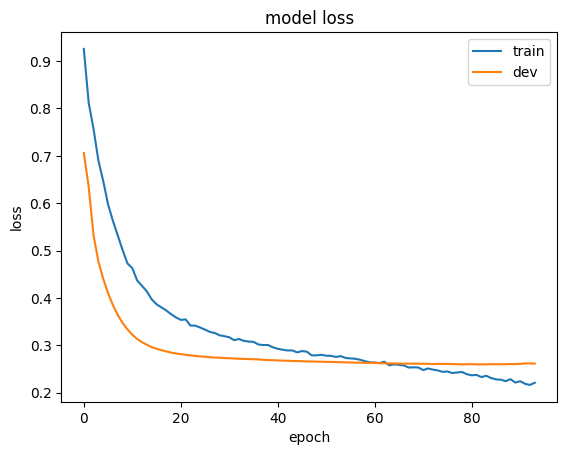

In [22]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

# Model 2

## Tokenize Data

In [40]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser","ner"])
nlp.add_pipe('sentencizer')

def tokenize_samples(samples):

  tokenized_samples = []
  for i in tqdm(range(len(samples))):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(x_train)
X_val_tokenized = tokenize_samples(x_dev)
X_test_tokenized = tokenize_samples(x_test)

  0%|          | 0/30000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 10000/10000 [01:54<00:00, 87.33it/s]


In [84]:
print('------------------------------------------------------------------------------------')
print(f'The processed text:\n {X_train_tokenized[10]}')

------------------------------------------------------------------------------------
The processed text:
 ['walk', 'theater', 'hour', 'seeing', 'people', 'cheating', 'wives', 'schtupping', 'like', 'dogs', 'rut', 'word', 'like', 'diabetic', 'equal', 'br', 'thanks', 'br', 'especially', 'frustrating', 'movie', 'lot', 'characters', 'interesting', 'given', 'fornicate', 'talk', 'swear', 'br', 'times', 'looked', 'sort', 'character', 'development', 'happened', 'sex', 'scene', 'plot', 'development', '1st', 'hour', 'summarized', 'murders', 'occur', 'vinnie', 'sees', 'murder', 'scene', 'vinnie', 'stares', 'moodily', 'atlantic', 'east', 'hudson', 'river', 'vinnie', 'cheats', 'wife', 'joey', 'sympathetic', 'character', 'gets', 'kicked', 'parents', 'house', 'wait', 'br', 'photography', 'interplay', 'characters', 'superb', 'flood', 'sex', 'vulgarity', 'hardly', 'worth', 'waiting', 'hour', 'happen', 'br', 'sorry', 'spike', 'lessons', 'notting', 'hill', 'shawshank', 'redemption', 'better', 'study', 'co

# FastText Initialization (Pre-trained model)

In [38]:
!pip install fasttext

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz
import fasttext


# Load and Initialize a object for a pre-trained fasttext model
fasttext_model = fasttext.load_model('cc.en.300.bin')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=e145241771152e76a67997a49dcca0f3e0ef9455bc289498091db757bf980e37
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
--2024-02-14 08:44:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.82, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   127MB/s    in 51s     

2024-02-14 08:44

### Calculate centroids

In [39]:
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS

def text_centroid(text, model):
  text_vec = []
  counter = 0
  for word in text:
    if word in STOP_WORDS:
          continue
    if counter == 0:
      text_vec = model.get_word_vector(word=word.lower())
    else:
      text_vec = np.add(text_vec, model.get_word_vector(word=word.lower()))
    counter += 1

  return np.asarray(text_vec) / counter

# ...calculate embeddings for whole corpus


In [43]:
from tqdm import tqdm

# Calculate centroids for train and val documents

X_train_centroids = [text_centroid(sent, fasttext_model) for sent in
                     tqdm(X_train_tokenized)]
X_train_centroids = np.stack(X_train_centroids, axis=0)

X_val_centroids = [text_centroid(sent, fasttext_model) for sent in tqdm(X_val_tokenized)]
X_val_centroids = np.stack(X_val_centroids, axis=0)

X_test_centroids = [text_centroid(sent, fasttext_model) for sent in tqdm(X_test_tokenized)]
X_test_centroids = np.stack(X_test_centroids, axis=0)


print(X_train_centroids.shape)

del fasttext_model # free up memory

100%|██████████| 10000/10000 [00:15<00:00, 662.12it/s]

(30000, 300)


In [64]:
X_train_centroids.shape[1]

300

# Fasttext (centroids) based MLP build and validation


In [68]:
from sklearn.metrics import f1_score, recall_score, precision_score

adam = Adam(learning_rate = 0.00004)

model2 = create_MLP_model(input_dim=300, activation_dense_layers=['relu', 'relu', 'relu'])
model2.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=["accuracy"]
    )

# Build the model and print the structure of our model before training
model2.build(300)  # We need to build our model in order to print the structure
print(model.summary())

# Add an early stopping callback to stop the epochs when we catch the best validation loss
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore best model weights when early stopping is triggered
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Start our training
history = model2.fit(
    X_train_centroids,
    y_train,
    validation_data=(X_val_centroids, y_dev),
    batch_size=128,
    epochs=200,
    shuffle=True,
    callbacks=[early_stopping_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               64128     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

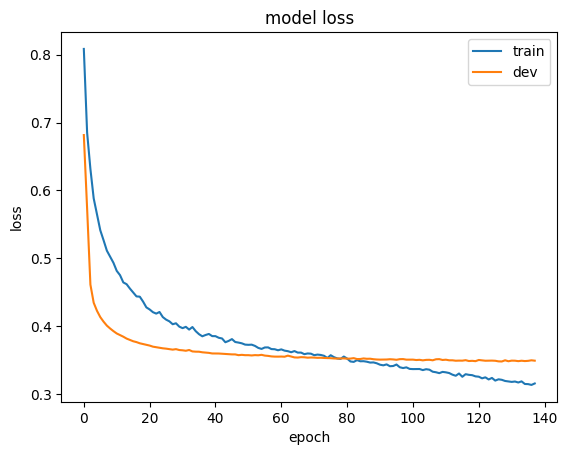

In [69]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [71]:
# predictions = model.predict(X_test_centroids)
# Assuming y_test is your ground truth labels
evaluation = model2.evaluate(X_test_centroids, y_test)
print('Test Set Evaluation:')
print(f"The loss of the test set is:{evaluation[0]:.3f},\nThe accuracy of the test set is: {evaluation[1]*100: .3f}%")

313/313 [==============================] - 1s 4ms/step - loss: 0.3451 - accuracy: 0.8495
Test Set Evaluation:
The loss of the test set is:0.345,
The accuracy of the test set is:  84.950%


# Results
* We will calculate precision, recall, F1, PR-auc scores first for each class and then macro average.

313/313 [==============================] - 1s 4ms/step


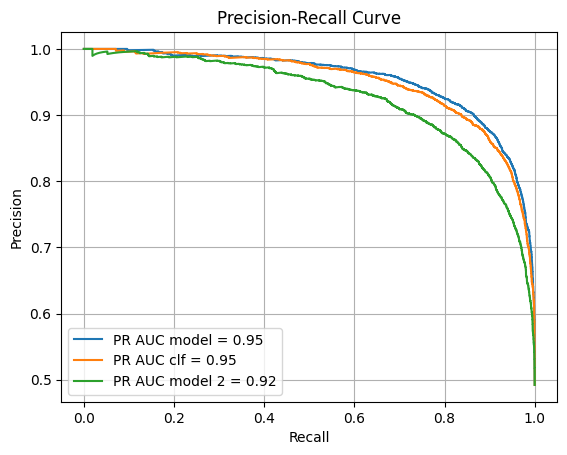

In [76]:
# Calculate model predictions
y_pred = model.predict(x_test_svd)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve for our model
plt.figure()
plt.plot(recall, precision, label='PR AUC model = %0.2f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')


# Predict probabilities
probs = clf.predict_proba(x_test_svd)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Calculate area under the curve (AUC) for PR curve
pr_auc = auc(recall, precision)

# Plot PR curve for baseline model
plt.plot(recall, precision, label=f'PR AUC clf = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)



y_pred = model2.predict(X_test_centroids)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve for our model
plt.plot(recall, precision, label='PR AUC model 2 = %0.2f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, roc_auc_score

# Calculate predictions for clf
train_preds_clf = clf.predict_proba(x_train_svd)
train_preds_bin_clf = clf.predict(x_train_svd)

dev_preds_clf = clf.predict_proba(x_val_svd)
dev_preds_bin_clf = clf.predict(x_val_svd)

test_preds_clf = clf.predict_proba(x_test_svd)
test_preds_bin_clf = clf.predict(x_test_svd)

# Calculate predictions for model
train_preds_model = model.predict(x_train_svd)
train_preds_bin_model = np.array([[1] if pred >= 0.5 else [0] for pred in train_preds_model])

dev_preds_model = model.predict(x_val_svd)
dev_preds_bin_model = np.array([[1] if pred >= 0.5 else [0] for pred in dev_preds_model])

test_preds_model = model.predict(x_test_svd)
test_preds_bin_model = np.array([[1] if pred >= 0.5 else [0] for pred in test_preds_model])

# Calculate predictions for model
train_preds_model2 = model2.predict(X_train_centroids)
train_preds_bin_model2 = np.array([[1] if pred >= 0.5 else [0] for pred in train_preds_model2])

dev_preds_model2 = model2.predict(X_val_centroids)
dev_preds_bin_model2 = np.array([[1] if pred >= 0.5 else [0] for pred in dev_preds_model2])

test_preds_model2 = model2.predict(X_test_centroids)
test_preds_bin_model2 = np.array([[1] if pred >= 0.5 else [0] for pred in test_preds_model2])



313/313 [==============================] - 1s 2ms/step


In [80]:
from operator import pos
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define a function to calculate metrics for each class including PR-AUC for MLP
def calculate_class_metrics_model(y_true, y_pred, y_probs):
    report = classification_report(y_true, y_pred, output_dict=True)
    # For class 1
    class_0_metrics = report['0']
    # For class 2
    class_1_metrics = report['1']

    # Calculate PR-AUC for each class
    precision, recall, _ = precision_recall_curve(y_true, y_probs, pos_label=1)
    pr_auc_class_1 = auc(recall, precision)

    # Its binary problem so 1-probability is the probability for class 0
    y_probs = 1-y_probs
    precision, recall, _ = precision_recall_curve(y_true, y_probs, pos_label=0)
    pr_auc_class_0 = auc(recall, precision)

    return class_0_metrics, class_1_metrics, pr_auc_class_0, pr_auc_class_1

# Define a function to calculate metrics for each class including PR-AUC for Logistic
def calculate_class_metrics_clf(y_true, y_pred, y_probs):
    report = classification_report(y_true, y_pred, output_dict=True)
    class_0_metrics = report['0']
    class_1_metrics = report['1']

    # Calculate PR-AUC for each class
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1],pos_label=1)
    pr_auc_class_1 = auc(recall, precision)

    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 0],pos_label=0)
    pr_auc_class_0 = auc(recall, precision)

    return class_0_metrics, class_1_metrics, pr_auc_class_0, pr_auc_class_1



# Calculate class metrics for clf
class_0_metrics_train_clf, class_1_metrics_train_clf, pr_auc_0_train_clf, pr_auc_1_train_clf = calculate_class_metrics_clf(y_train, train_preds_bin_clf, train_preds_clf)
class_0_metrics_dev_clf, class_1_metrics_dev_clf, pr_auc_0_dev_clf, pr_auc_1_dev_clf = calculate_class_metrics_clf(y_dev, dev_preds_bin_clf, dev_preds_clf)
class_0_metrics_test_clf, class_1_metrics_test_clf, pr_auc_0_test_clf, pr_auc_1_test_clf = calculate_class_metrics_clf(y_test, test_preds_bin_clf, test_preds_clf)

# Calculate class metrics for model
class_0_metrics_train_model, class_1_metrics_train_model, pr_auc_0_train_model, pr_auc_1_train_model = calculate_class_metrics_model(y_train, train_preds_bin_model, train_preds_model)
class_0_metrics_dev_model, class_1_metrics_dev_model, pr_auc_0_dev_model, pr_auc_1_dev_model = calculate_class_metrics_model(y_dev, dev_preds_bin_model, dev_preds_model)
class_0_metrics_test_model, class_1_metrics_test_model, pr_auc_0_test_model, pr_auc_1_test_model = calculate_class_metrics_model(y_test, test_preds_bin_model,test_preds_model)

class_0_metrics_train_model2, class_1_metrics_train_model2, pr_auc_0_train_model2, pr_auc_1_train_model2 = calculate_class_metrics_model(y_train, train_preds_bin_model2, train_preds_model2)
class_0_metrics_dev_model2, class_1_metrics_dev_model2, pr_auc_0_dev_model2, pr_auc_1_dev_model2 = calculate_class_metrics_model(y_dev, dev_preds_bin_model2, dev_preds_model2)
class_0_metrics_test_model2, class_1_metrics_test_model2, pr_auc_0_test_model2, pr_auc_1_test_model2 = calculate_class_metrics_model(y_test, test_preds_bin_model2,test_preds_model2)



# Create separate DataFrames for training, development, and test results for each class
train_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model 2'],
    'Class 0 Precision': [class_0_metrics_train_clf['precision'], class_0_metrics_train_model['precision'],class_0_metrics_train_model2['precision']],
    'Class 1 Precision': [class_1_metrics_train_clf['precision'], class_1_metrics_train_model['precision'],class_1_metrics_train_model2['precision']],
    'Class 0 Recall': [class_0_metrics_train_clf['recall'], class_0_metrics_train_model['recall'],class_0_metrics_train_model2['recall']],
    'Class 1 Recall': [class_1_metrics_train_clf['recall'], class_1_metrics_train_model['recall'],class_1_metrics_train_model2['recall']],
    'Class 0 F1-score': [class_0_metrics_train_clf['f1-score'], class_0_metrics_train_model['f1-score'],class_0_metrics_train_model2['f1-score']],
    'Class 1 F1-score': [class_1_metrics_train_clf['f1-score'], class_1_metrics_train_model['f1-score'],class_1_metrics_train_model2['f1-score']],
    'PR AUC Class 0': [pr_auc_0_train_clf, pr_auc_0_train_model,pr_auc_0_train_model2],
    'PR AUC Class 1': [pr_auc_1_train_clf, pr_auc_1_train_model,pr_auc_1_train_model2]
})

dev_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model2'],
    'Class 0 Precision': [class_0_metrics_dev_clf['precision'], class_0_metrics_dev_model['precision'],class_0_metrics_dev_model2['precision']],
    'Class 1 Precision': [class_1_metrics_dev_clf['precision'], class_1_metrics_dev_model['precision'],class_1_metrics_dev_model2['precision']],
    'Class 0 Recall': [class_0_metrics_dev_clf['recall'], class_0_metrics_dev_model['recall'],class_0_metrics_dev_model2['recall']],
    'Class 1 Recall': [class_1_metrics_dev_clf['recall'], class_1_metrics_dev_model['recall'],class_1_metrics_dev_model2['recall']],
    'Class 0 F1-score': [class_0_metrics_dev_clf['f1-score'], class_0_metrics_dev_model['f1-score'],class_0_metrics_dev_model2['f1-score']],
    'Class 1 F1-score': [class_1_metrics_dev_clf['f1-score'], class_1_metrics_dev_model['f1-score'],class_1_metrics_dev_model2['f1-score']],
    'PR AUC Class 0': [pr_auc_0_dev_clf, pr_auc_0_dev_model,pr_auc_0_dev_model2],
    'PR AUC Class 1': [pr_auc_1_dev_clf, pr_auc_1_dev_model,pr_auc_1_dev_model2]
})

test_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model2'],
    'Class 0 Precision': [class_0_metrics_test_clf['precision'], class_0_metrics_test_model['precision'], class_0_metrics_test_model2['precision']],
    'Class 1 Precision': [class_1_metrics_test_clf['precision'], class_1_metrics_test_model['precision'],class_1_metrics_test_model2['precision']],
    'Class 0 Recall': [class_0_metrics_test_clf['recall'], class_0_metrics_test_model['recall'],class_0_metrics_test_model2['recall']],
    'Class 1 Recall': [class_1_metrics_test_clf['recall'], class_1_metrics_test_model['recall'],class_1_metrics_test_model2['recall']],
    'Class 0 F1-score': [class_0_metrics_test_clf['f1-score'], class_0_metrics_test_model['f1-score'],class_0_metrics_test_model2['f1-score']],
    'Class 1 F1-score': [class_1_metrics_test_clf['f1-score'], class_1_metrics_test_model['f1-score'],class_1_metrics_test_model2['f1-score']],
    'PR AUC Class 0': [pr_auc_0_test_clf, pr_auc_0_test_model,pr_auc_0_test_model2],
    'PR AUC Class 1': [pr_auc_1_test_clf, pr_auc_1_test_model,pr_auc_1_test_model2]
})

from tabulate import tabulate

# Print training class metrics
print("Training Class Metrics:")
print(tabulate(train_class_metrics_df, headers='keys', tablefmt='psql'))

# Print development class metrics
print("\nDevelopment Class Metrics:")
print(tabulate(dev_class_metrics_df, headers='keys', tablefmt='psql'))

# Print test class metrics
print("\nTest Class Metrics:")
print(tabulate(test_class_metrics_df, headers='keys', tablefmt='psql'))


Training Class Metrics:
+----+--------------+---------------------+---------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+
|    | Classifier   |   Class 0 Precision |   Class 1 Precision |   Class 0 Recall |   Class 1 Recall |   Class 0 F1-score |   Class 1 F1-score |   PR AUC Class 0 |   PR AUC Class 1 |
|----+--------------+---------------------+---------------------+------------------+------------------+--------------------+--------------------+------------------+------------------|
|  0 | clf          |            0.894852 |            0.877861 |         0.8751   |         0.897227 |           0.884866 |           0.887439 |         0.95588  |         0.953182 |
|  1 | model        |            0.933351 |            0.928676 |         0.928248 |         0.933751 |           0.930792 |           0.931206 |         0.981994 |         0.980722 |
|  2 | model 2      |            0.895452 |            0

In [81]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, auc
import pandas as pd

def calculate_metrics(y_true, y_pred, y_probs):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall_auc, precision_auc)
    return precision, recall, f1, pr_auc

# Calculate class metrics for clf
precision_train_clf, recall_train_clf, f1_train_clf, pr_auc_train_clf = calculate_metrics(y_train, train_preds_bin_clf, train_preds_clf[:,1])
precision_dev_clf, recall_dev_clf, f1_dev_clf, pr_auc_dev_clf = calculate_metrics(y_dev, dev_preds_bin_clf, dev_preds_clf[:,1])
precision_test_clf, recall_test_clf, f1_test_clf, pr_auc_test_clf = calculate_metrics(y_test, test_preds_bin_clf, test_preds_clf[:,1])

# Calculate class metrics for model
precision_train_model, recall_train_model, f1_train_model, pr_auc_train_model = calculate_metrics(y_train, train_preds_bin_model, train_preds_model)
precision_dev_model, recall_dev_model, f1_dev_model, pr_auc_dev_model = calculate_metrics(y_dev, dev_preds_bin_model, dev_preds_model)
precision_test_model, recall_test_model, f1_test_model, pr_auc_test_model = calculate_metrics(y_test, test_preds_bin_model,test_preds_model)

# Calculate class metrics for model2
precision_train_model2, recall_train_model2, f1_train_model2, pr_auc_train_model2 = calculate_metrics(y_train, train_preds_bin_model2, train_preds_model2)
precision_dev_model2, recall_dev_model2, f1_dev_model2, pr_auc_dev_model2 = calculate_metrics(y_dev, dev_preds_bin_model2, dev_preds_model2)
precision_test_model2, recall_test_model2, f1_test_model2, pr_auc_test_model2 = calculate_metrics(y_test, test_preds_bin_model2,test_preds_model2)

# Create separate DataFrames for training, development, and test results for each class
train_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model2'],
    'Precision': [precision_train_clf, precision_train_model,precision_train_model2],
    'Recall': [recall_train_clf, recall_train_model,recall_train_model2],
    'F1': [f1_train_clf, f1_train_model,f1_train_model2],
    'PR AUC': [pr_auc_train_clf, pr_auc_train_model,pr_auc_train_model2]
})

dev_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model2'],
    'Precision': [precision_train_clf, precision_dev_model, precision_dev_model2],
    'Recall': [recall_dev_clf, recall_dev_model,recall_dev_model2],
    'F1': [f1_dev_clf, f1_dev_model,f1_dev_model2],
    'PR AUC': [pr_auc_dev_clf, pr_auc_dev_model,pr_auc_dev_model2]
})

test_class_metrics_df = pd.DataFrame({
    'Classifier': ['clf', 'model','model2'],
    'Precision': [precision_test_clf, precision_test_model,precision_test_model2],
    'Recall': [recall_test_clf, recall_test_model,recall_test_model2],
    'F1': [f1_test_clf, f1_test_model,f1_test_model2],
    'PR AUC': [pr_auc_test_clf, pr_auc_test_model,pr_auc_test_model2]
})

from tabulate import tabulate

# Print training class metrics
print("Training Class Metrics:")
print(tabulate(train_class_metrics_df, headers='keys', tablefmt='psql'))

# Print development class metrics
print("\nDevelopment Class Metrics:")
print(tabulate(dev_class_metrics_df, headers='keys', tablefmt='psql'))

# Print test class metrics
print("\nTest Class Metrics:")
print(tabulate(test_class_metrics_df, headers='keys', tablefmt='psql'))


Training Class Metrics:
+----+--------------+-------------+----------+----------+----------+
|    | Classifier   |   Precision |   Recall |       F1 |   PR AUC |
|----+--------------+-------------+----------+----------+----------|
|  0 | clf          |    0.886356 | 0.886164 | 0.886152 | 0.953182 |
|  1 | model        |    0.931013 | 0.930999 | 0.930999 | 0.980722 |
|  2 | model2       |    0.882603 | 0.882162 | 0.882132 | 0.953328 |
+----+--------------+-------------+----------+----------+----------+

Development Class Metrics:
+----+--------------+-------------+----------+----------+----------+
|    | Classifier   |   Precision |   Recall |       F1 |   PR AUC |
|----+--------------+-------------+----------+----------+----------|
|  0 | clf          |    0.886356 | 0.887398 | 0.887459 | 0.954233 |
|  1 | model        |    0.894693 | 0.894685 | 0.894689 | 0.959042 |
|  2 | model2       |    0.849115 | 0.848776 | 0.848833 | 0.924528 |
+----+--------------+-------------+----------+-----